In [91]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
# %reload_ext autoreload

In [93]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import skimage as sk
import skimage.io as io
import itertools
import filters
import homography
import rectification
import utils
from mops import *

# Detect Corners

In [4]:
im1 = utils.read_img("data/plush1.jpg")
im2 = utils.read_img("data/plush2.jpg")

951


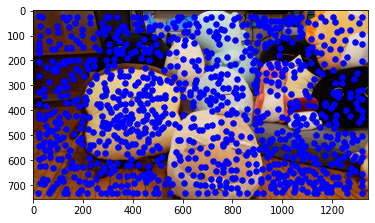

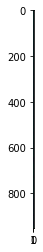

In [94]:
corners1, strengths1 = detect_corners(im1)
print(len(corners1))
utils.plot_corners(im1, corners1)
plt.imshow(strength1)

965


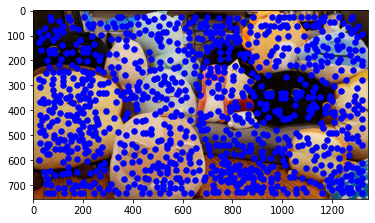

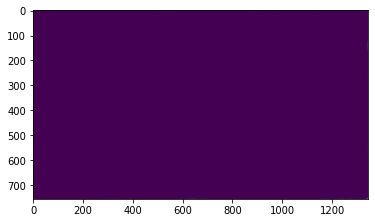

In [95]:
corners2, strengths2 = detect_corners(im2)
print(len(corners2))
utils.plot_corners(im2, corners2)
plt.imshow(strengths2)

# Do Adaptive Non-Maximal Suppression

In [ ]:
keep = anms(corners1, strength1)

# Match Features

In [42]:
patches1 = get_patches(im1, corners1)
patches2 = get_patches(im2, corners2)

In [88]:
features1 = [Feature(c, p) for c, p in zip(corners1, patches1)]
features2 = [Feature(c, p) for c, p in zip(corners2, patches2)]

In [98]:
combos = np.array(list(itertools.product(features1, features2)))
combos.shape

(917715, 2)

In [99]:
dist2(patches1, patches2)

ValueError: too many values to unpack (expected 2)

In [100]:
patches1.shape

(951, 8, 8)

In [108]:
c1 = corners1
c2 = corners2
ndata, dimx = c1.shape #num_points1, dim1
ncenters, dimc = c2.shape #num_points2, dim2

In [109]:
np.ones((ncenters, 1)).shape

(965, 1)

In [107]:
np.sum((x ** 2).T, axis=0).shape

(951,)

In [111]:
a = (np.ones((ncenters, 1)) * np.sum((x ** 2).T, axis=0)).T
a.shape

(951, 965)

In [114]:
b = np.ones((ndata, 1)) * np.sum((c ** 2).T, axis=0)
b.shape

(951, 965)